In [1]:
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
import numpy as np

C:\Users\miked\AppData\Local\Temp\ipykernel_36532\1377437179.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<h1> Load Data </h1>

In [2]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')

In [3]:
original_movie_ids = set(movies_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
movies_df["movieId"] = movies_df["movieId"].map(movie_id_map)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
original_movie_ids = set(ratings_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
ratings_df["movieId"] = ratings_df["movieId"].map(movie_id_map)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


<h1> Build Raiding Matrix </h1>

In [5]:


# Get the unique user IDs and movie IDs
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()

# Create a dictionary to map movie IDs to column indices
movie_id_map = {movie_id: i for i, movie_id in enumerate(movie_ids)}





In [6]:
len(movie_ids)

59047

In [7]:

# Initialize lists to store the row indices, column indices, and ratings
row_indices = []
col_indices = []
ratings = []

# Iterate over the ratings dataframe
for _, row in ratings_df.iterrows():
    row_indices.append(int(row['userId']))
    col_indices.append(int(row['movieId']))
    ratings.append(row['rating'])

In [8]:
# Create the sparse spatial matrix
sparse_matrix = csr_matrix((ratings, (row_indices, col_indices)))
sparse_matrix.shape

(162542, 59047)

In [9]:
coo_matrix = coo_matrix((ratings, (row_indices, col_indices)))

<h1> Define training function </h1>

In [10]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [11]:
def getColumnAverage(matrix, column_index):
    col = matrix.getcol(column_index)
    non_zero_column = col[col.nonzero()]
    return Average(np.squeeze(np.asarray(non_zero_column)))

In [33]:
from sklearn.base import BaseEstimator

class AverageRatingModel(BaseEstimator):
    avg_ratings_df = None  
        
    def fit(self, training_ratings_matrix: csc_matrix):
        # Calculate the column-wise average of the sparse matrix
        averages = training_ratings_matrix.sum(0) / training_ratings_matrix.getnnz(0)
        self.avg_ratings_df = pd.DataFrame(averages[0])
        
    def predict(self, user_ratings_matrix):
        
        # Get the number of rows and columns in the user_ratings_matrix
        num_rows, num_cols = user_ratings_matrix.shape
        
        # Iterate over each row (user) and column (movie)
        for i in range(num_rows):
            for j in range(num_cols):
                # Check if the value is null
                if user_ratings_matrix[i, j] == 0:
                    # Replace the null value with a value from avg_ratings_df
                    user_ratings_matrix[i, j] = self.avg_ratings_df.iloc[0,j]
                    print(self.avg_ratings_df.iloc[0,j])
        # Return the modified user_ratings_matrix
        return user_ratings_matrix


<h1> Run Training </h1>

In [15]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(sparse_matrix, test_size=0.2, train_size=0.8)


In [16]:
avg_rat_model = AverageRatingModel()

avg_rat_model.fit(train_dataset)

C:\Users\miked\AppData\Local\Temp\ipykernel_36532\2655095998.py:8: RuntimeWarning: invalid value encountered in divide
  averages = training_ratings_matrix.sum(0) / training_ratings_matrix.getnnz(0)


In [17]:
avg_rat_model.avg_ratings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,59037,59038,59039,59040,59041,59042,59043,59044,59045,59046
0,NaN,3.892577,3.251305,3.14285,2.842317,3.044302,3.8558,3.358887,3.117674,2.995497,...,2.7,2.8,2.166667,2.5,2.166667,2.166667,3.416667,3.081818,NaN,3.5


<h1> Evaluate </h1>

In [18]:
import numpy as np
from scipy.sparse import coo_matrix, lil_matrix

# Initialize empty lists to store the row indices, column indices, and values
row_indices_80 = []
col_indices_80 = []
values_80 = []

row_indices_20 = []
col_indices_20 = []
values_20 = []

# Iterate over each row in test_dataset
for row_idx in range(test_dataset.shape[0]):
    # Get the non-zero indices and values for the current row
    non_zero_indices = test_dataset[row_idx].nonzero()[1]
    non_zero_values = test_dataset[row_idx].data
    
    # Calculate the number of non-zero values to include in the 80% matrix
    num_values_80 = int(len(non_zero_values) * 0.8)
    
    # Split the non-zero indices and values into 80% and 20% portions
    indices_80 = np.random.choice(non_zero_indices, size=num_values_80, replace=False)
    indices_20 = np.setdiff1d(non_zero_indices, indices_80)
    
    values_80.extend(non_zero_values[np.isin(non_zero_indices, indices_80)])
    values_20.extend(non_zero_values[np.isin(non_zero_indices, indices_20)])
    
    row_indices_80.extend([row_idx] * len(indices_80))
    row_indices_20.extend([row_idx] * len(indices_20))
    
    col_indices_80.extend(indices_80)
    col_indices_20.extend(indices_20)

# Create the 80% and 20% csc_matrix objects
input_ratings = csc_matrix((values_80, (row_indices_80, col_indices_80)))
test_ratings = csc_matrix((values_20, (row_indices_20, col_indices_20)))



In [55]:
def compare_ratings(predictions: csc_matrix, test_ratings: csc_matrix):
    test_ratings_array = []
    predictions_array = []
    num_rows, num_cols = test_ratings.shape
    for i in range(0, num_rows):
        for j in range(0, num_cols):
            if(test_ratings[i,j] != 0): #only take the records that have an actual rating
                test_ratings_array.append(test_ratings[i,j])
                predictions_array.append(predictions[i,j])
    return test_ratings_array, predictions_array


In [20]:
lil_input = lil_matrix(input_ratings)

In [56]:
test_ratings_array = []
predictions_array = []
# Batch the code by every 100 records
for i in range(0, lil_input.shape[0], 10):
    batch_predictions = avg_rat_model.predict(lil_input[i:i+10])
    batch_test_ratings = test_ratings[i:i+10]
    tr, pred = compare_ratings(batch_predictions, batch_test_ratings)
    test_ratings_array.extend(tr)
    predictions_array.extend(pred)
    break

rmse:  0.6210781340219528


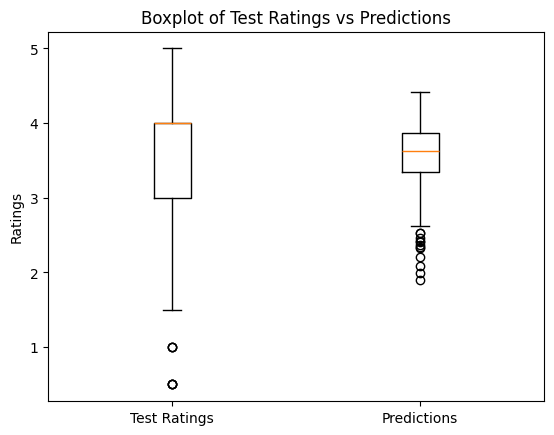

r2:  0.24131473544801152
Fraction of user-movie pairs with non-zero predicted ratings  1.0
Fraction of user-movie pairs with non-zero predicted ratings  0.7294117647058823


In [62]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
#Root mean-squared error (RMSE)
rmse = mean_squared_error(test_ratings_array, predictions_array)
print('rmse: ', rmse)
#Boxplot of true vs predicted ratings
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Create a boxplot of test_ratings_array and predictions_array
ax.boxplot([test_ratings_array, predictions_array])

# Set the labels for x-axis and y-axis
ax.set_xticklabels(['Test Ratings', 'Predictions'])
ax.set_ylabel('Ratings')

# Set the title of the plot
ax.set_title('Boxplot of Test Ratings vs Predictions')

# Show the plot
plt.show()

#Pearson's Correlation Coefficient (R2)
r2 = r2_score(test_ratings_array, predictions_array) 
print('r2: ', r2)
#Fraction of user-movie pairs with non-zero predicted ratings
print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(predictions_array)/len(predictions_array))
#Fraction of user-movie ratings with a predicted values (recall)
subtracted_array = np.subtract(predictions_array, test_ratings_array) #zeros mean perfect match
subtracted_array_rounded = np.round(subtracted_array * 2) / 2 #round to nearest 0.5

print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(subtracted_array_rounded)/len(subtracted_array))
#RMSE is appropriate if we want to exactly the predict the ratings of the users.  R2 is useful if we don't care about the ranges of the ratings, just that the predicted ratings rank items in a manner consistent with the user-provided ratings.  The MovieLens ratings are in increments of 0.5.  This makes it easy to visualize the relationships between the user-provided and predicted ratings using a boxplot (user-provided ratings on the X axis, predicted ratings on the Y axis).
